In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Calibri'

import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

import matplotlib.patches as mpatches
from scipy.stats import wilcoxon, ttest_ind
from scipy.stats import pearsonr

from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.expand_frame_repr', True)
import warnings
warnings.filterwarnings('ignore')

path = '/home/ripper8/projects/working_data/GRNv3knockouts/analysis'
experiments = ['reg10m2', 'reg2m2']


In [134]:
traits = ['disp_y', 'distance', 'extremities_prop', 'symmetry']

df_traits = {}
df_categ_traits = {}

for trait in traits:
    print('>>>>>',trait)
    df_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effects_{trait}.csv')
    df_traits[trait]['epistasis_percent'] = df_traits[trait]['positive'] + df_traits[trait]['negative']
    df_traits[trait]['avg_negative']  = df_traits[trait]['avg_negative'] * -1

    df_categ_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effectscateg_{trait}.csv')

   

>>>>> disp_y
>>>>> distance
>>>>> extremities_prop
>>>>> symmetry


>>>>> disp_y
>> reg10m2


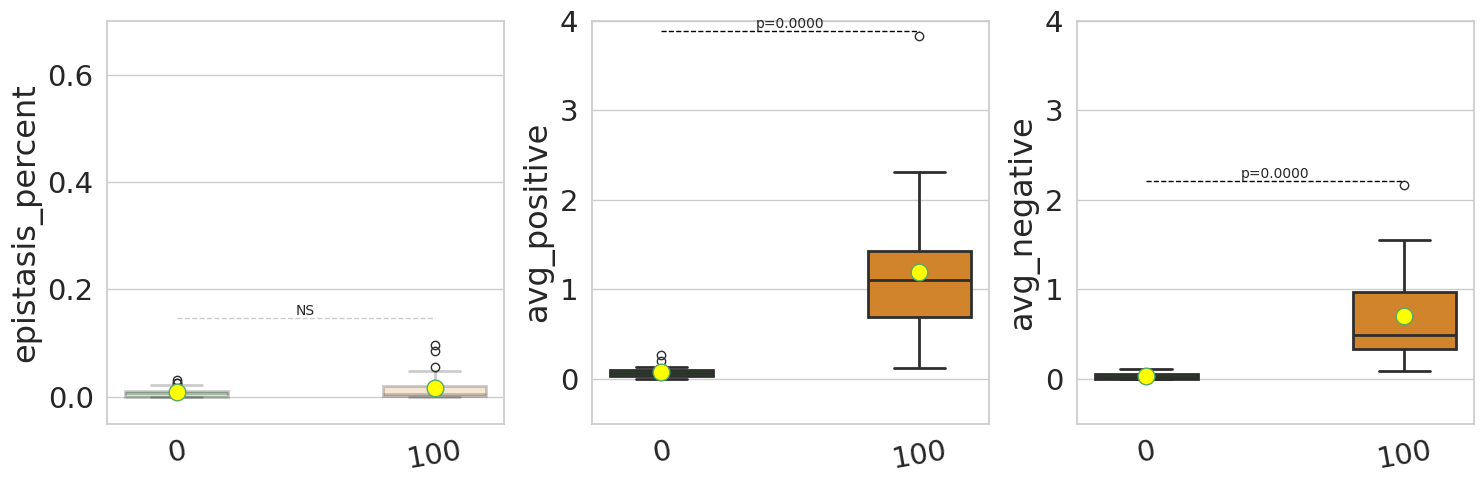

>> reg2m2


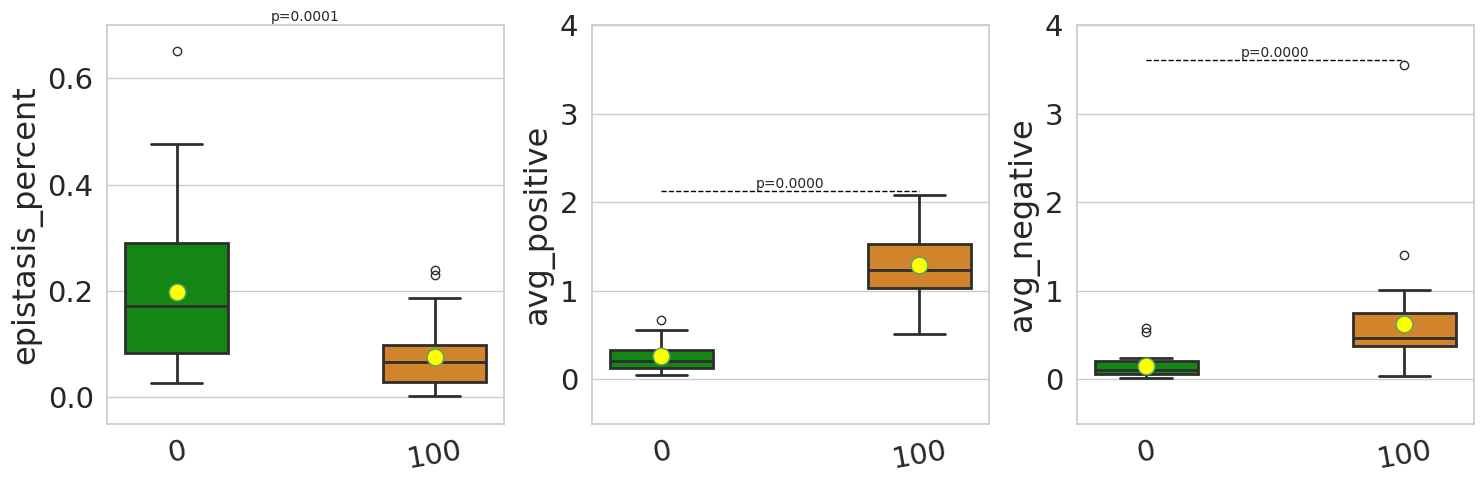

>>>>> distance
>> reg10m2


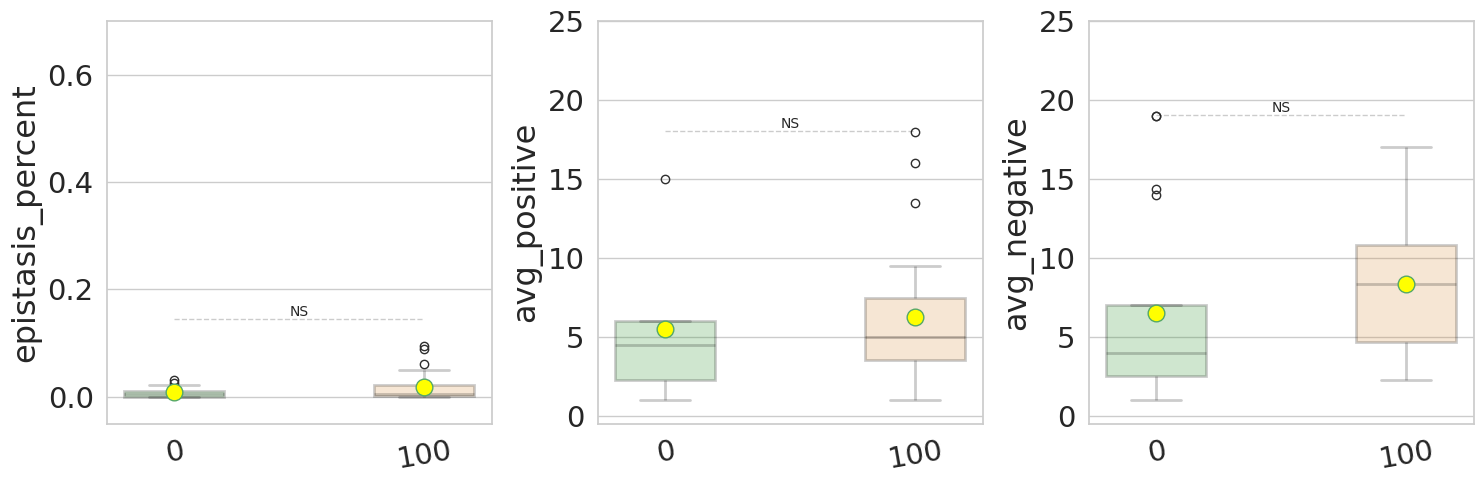

>> reg2m2


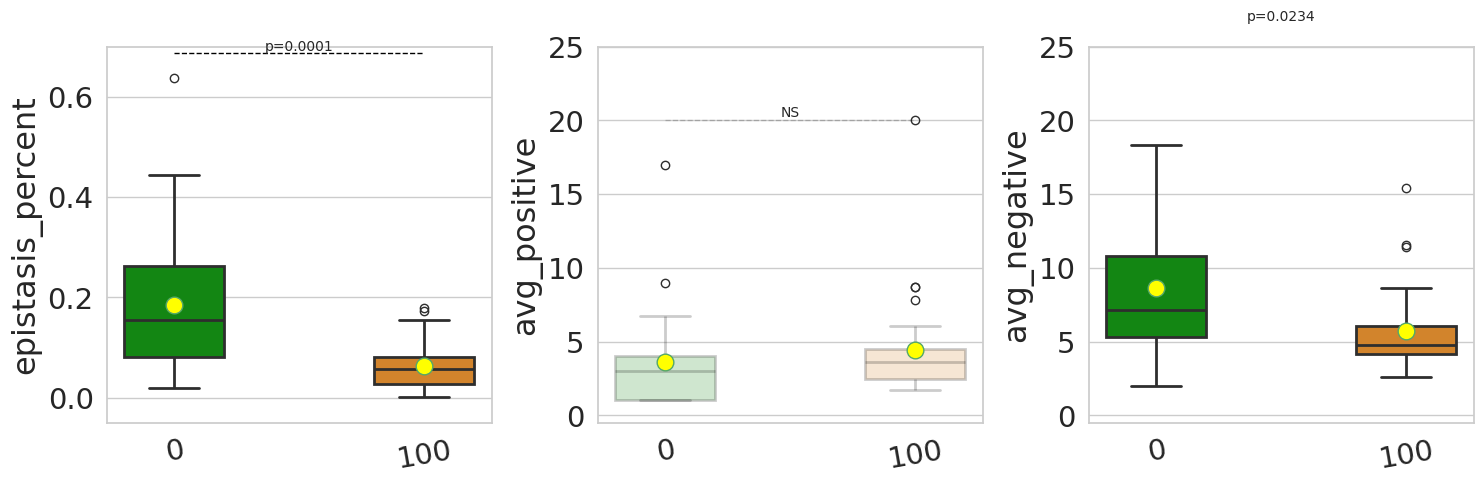

>>>>> extremities_prop
>> reg10m2


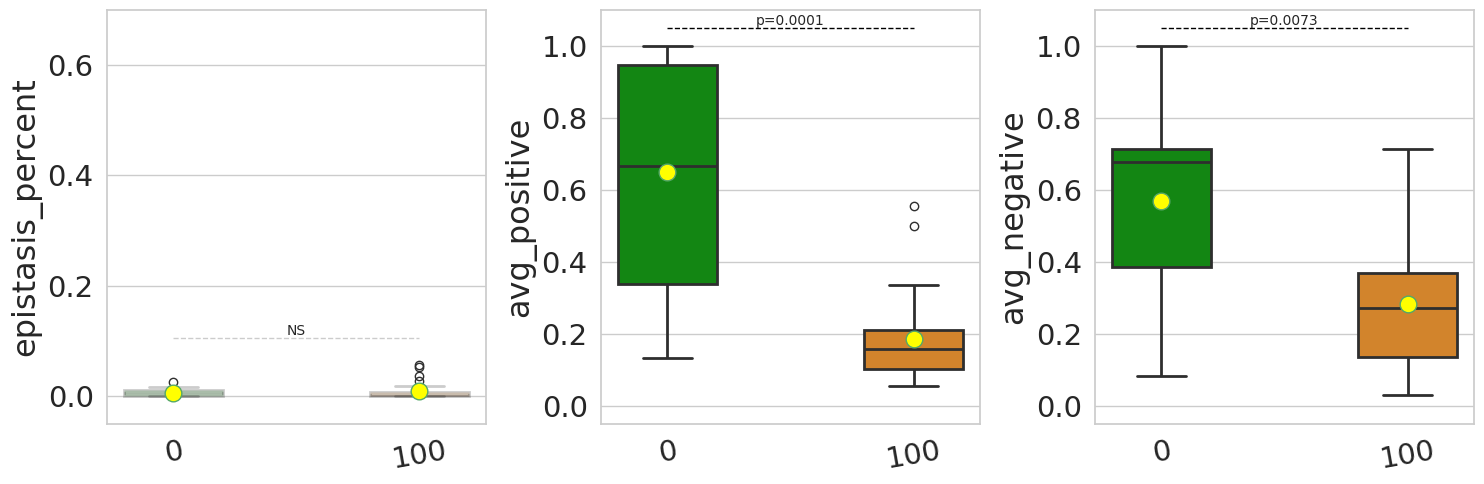

>> reg2m2


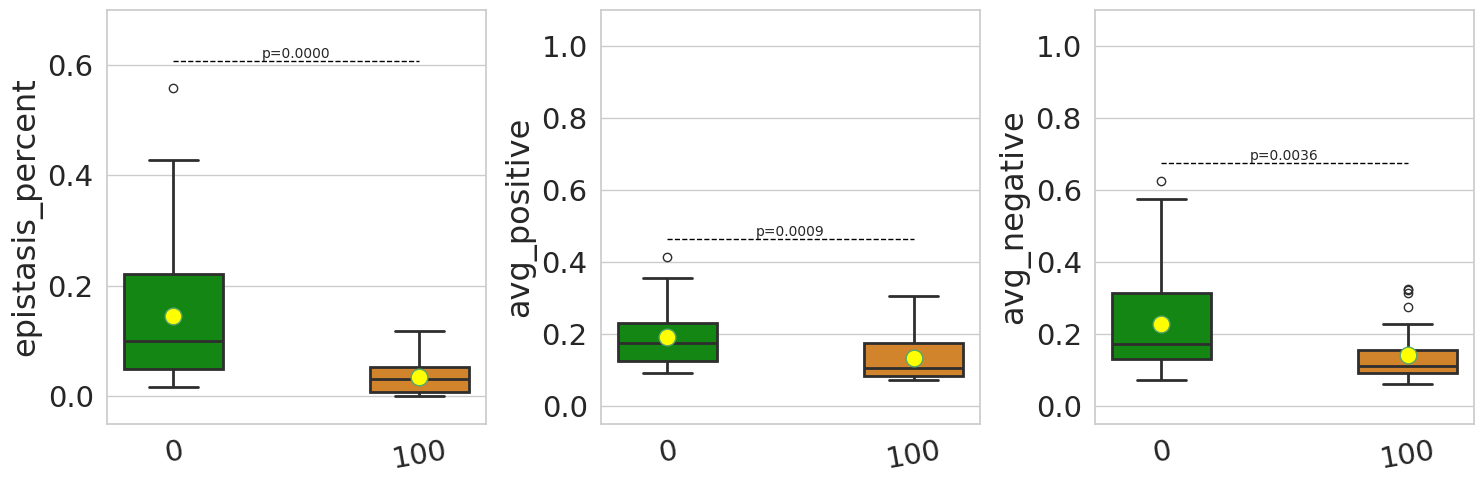

>>>>> symmetry
>> reg10m2


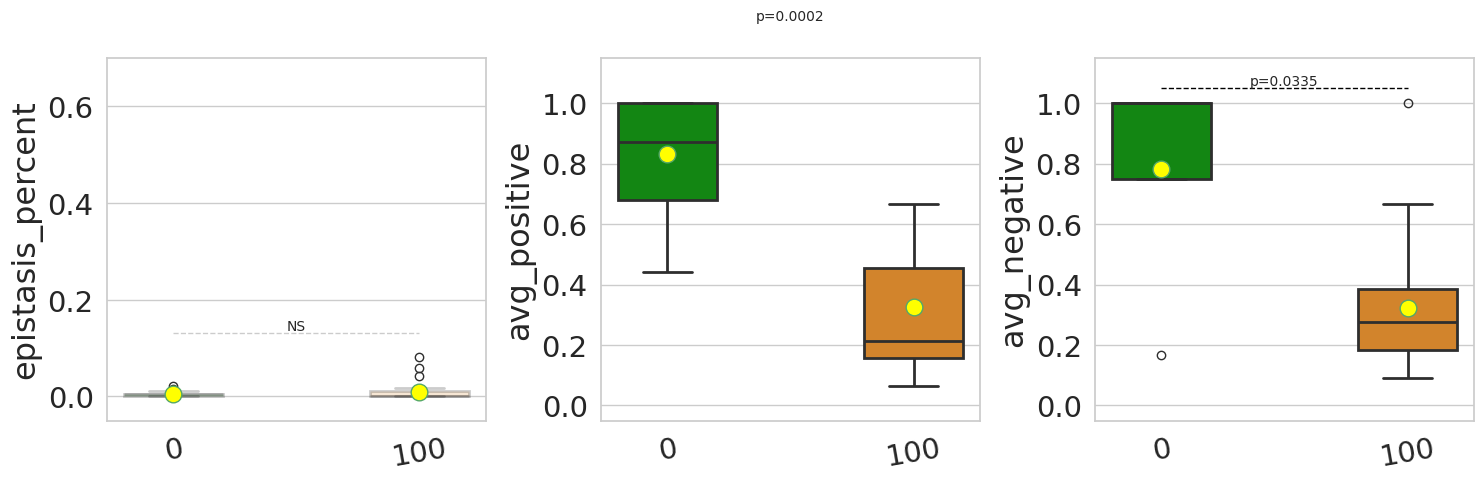

>> reg2m2


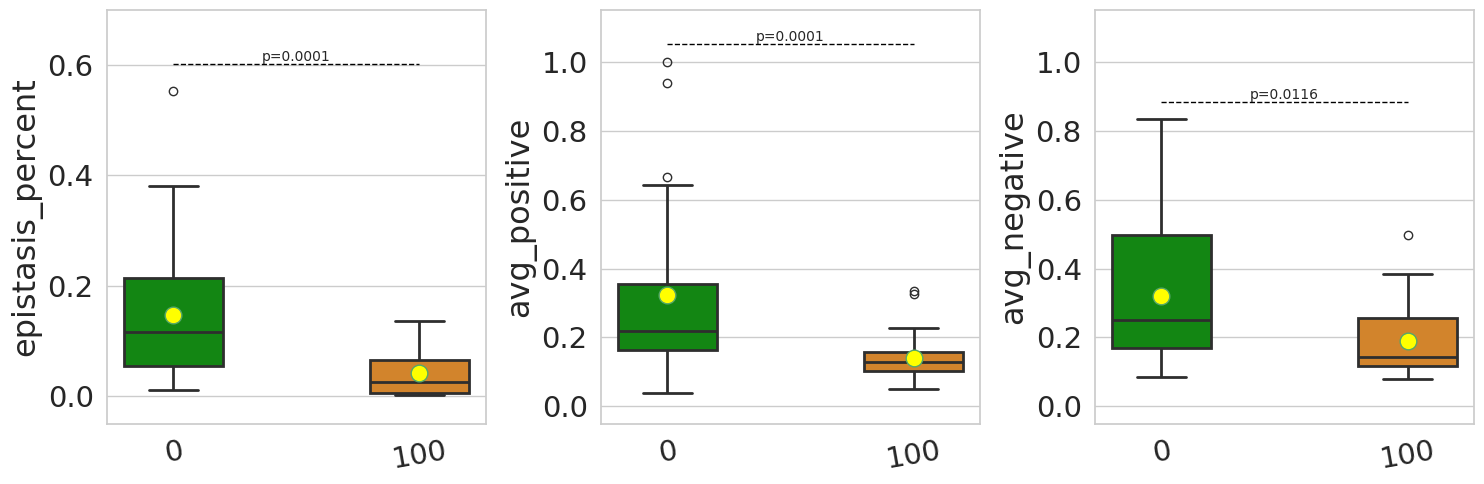

In [135]:


### EPISTASIS CHANGES ###

metrics = ['epistasis_percent',  'avg_positive',  'avg_negative']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    

    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







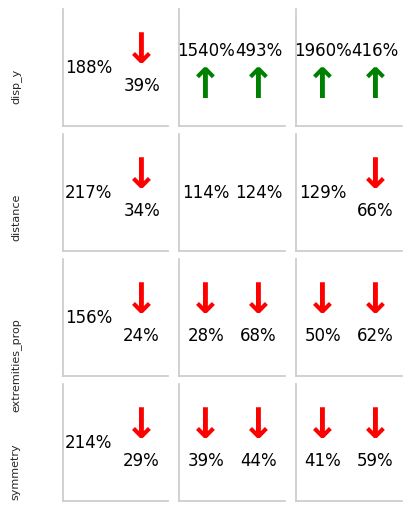

In [136]:
# Create a figure for the grid
fig, ax = plt.subplots(len(traits), len(metrics), figsize=(4, 5), constrained_layout=True)

for i, trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True)
    for j, metric in enumerate(metrics):
        for k, exp in enumerate(experiments):
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')

            # Calculate the ratio of gen 100 to gen 0
            ratio = (avg_end_gen / avg_ini_gen) * 100

            # Determine the subcell width and x-position for horizontal stacking
            subcell_width = 1.0 / len(experiments)
            x_position = k * subcell_width

            # Determine what to display in the subcell
            if p_value >= 0.05:
                display_text = f'{ratio:.0f}%'
               # ax[i, j].plot([x_position + 0.15 * subcell_width, x_position + 0.7 * subcell_width], [0.5, 0.5], color='black', linewidth=2)
                ax[i, j].text(x_position + subcell_width / 2, 0.5, display_text, ha='center', va='center', fontsize=12, color='black')
            else:
                display_text = f'{ratio:.0f}%'
                if ratio > 100:
                    # Green arrow pointing up, below the text
                    ax[i, j].text(x_position + subcell_width / 2, 0.65, display_text, ha='center', va='center', fontsize=12, color='black')
                    ax[i, j].annotate('↑', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                                      textcoords='axes fraction', ha='center', va='center', color='green', fontsize=30, fontweight='bold')
                else:
                    # Red arrow pointing down, above the text
                    ax[i, j].text(x_position + subcell_width / 2, 0.35, display_text, ha='center', va='center', fontsize=12, color='black')
                    ax[i, j].annotate('↓', xy=(x_position + subcell_width / 2, 0.65), xytext=(x_position + subcell_width / 2, 0.65),
                                      textcoords='axes fraction', ha='center', va='center', color='red', fontsize=30, fontweight='bold')

            # Draw the borders for each metric cell and subcells
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].spines['left'].set_visible(True)        

            # Draw the borders for the subcells
            ax[i, j].add_patch(plt.Rectangle((x_position, 0), subcell_width, 1, fill=False, edgecolor='white', lw=0.5))

        # Set the grid borders
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Set row labels for traits
for i, trait in enumerate(traits):
    ax[i, 0].set_ylabel(trait, fontsize=8, rotation=90, labelpad=30, ha='right')

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_change.png', dpi=300, bbox_inches='tight')


>>>>> disp_y
>> reg10m2


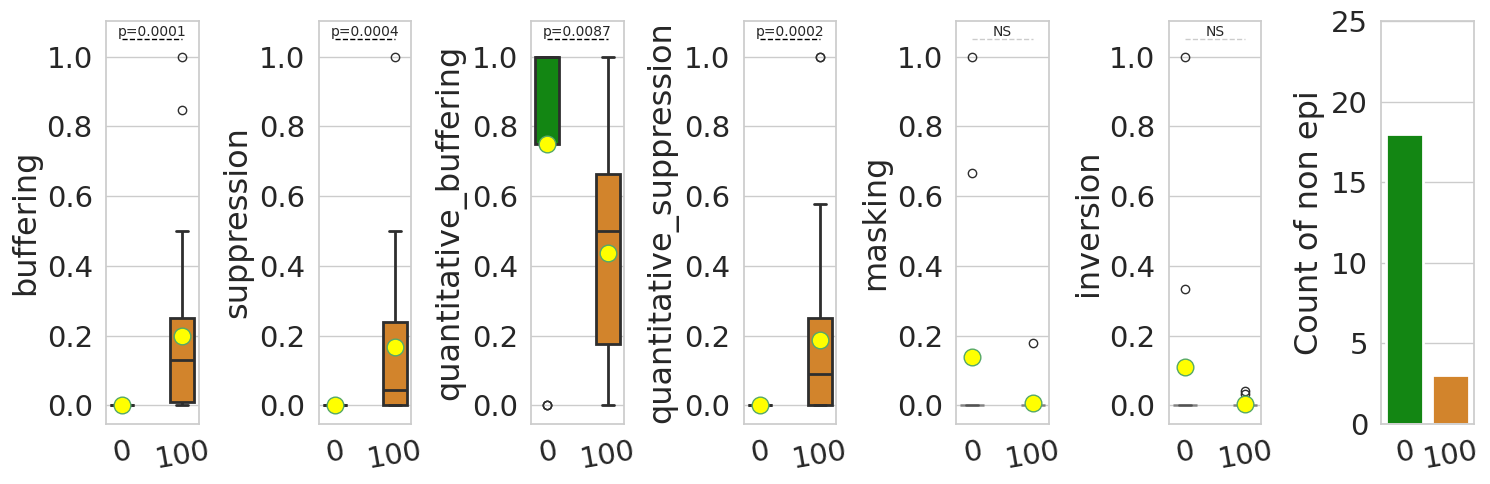

>> reg2m2


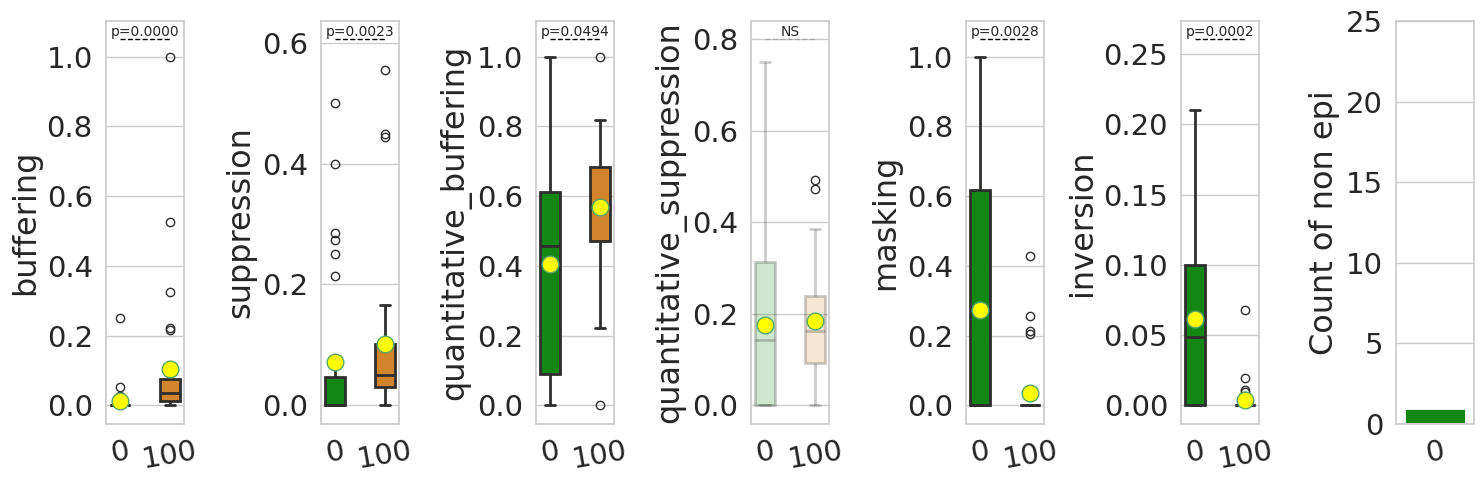

>>>>> distance
>> reg10m2


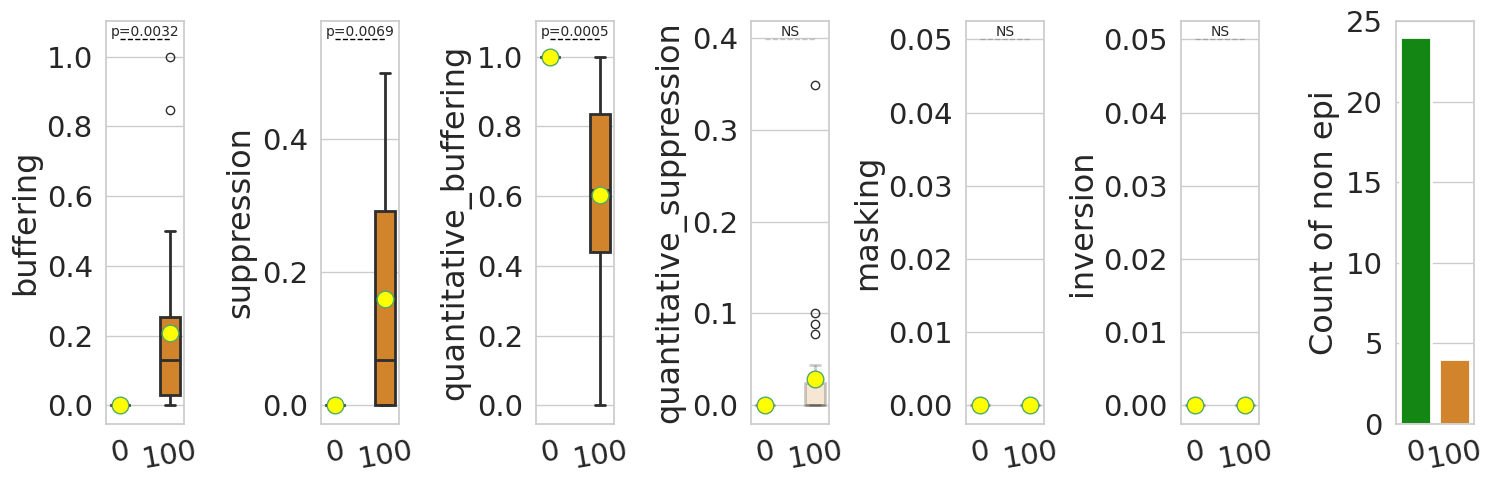

>> reg2m2


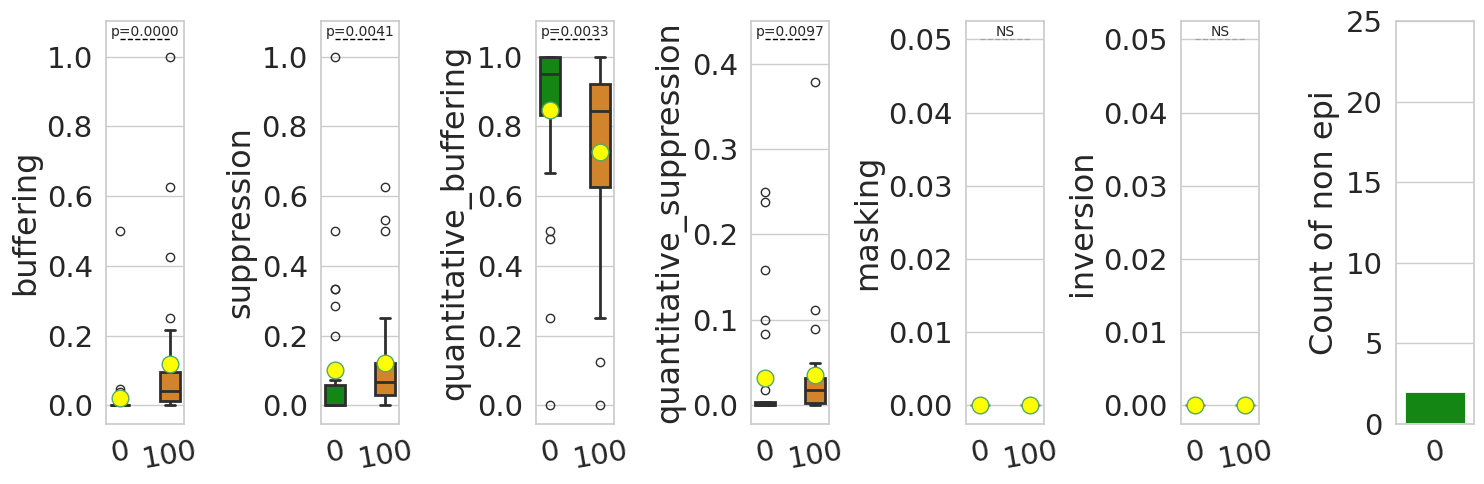

>>>>> extremities_prop
>> reg10m2


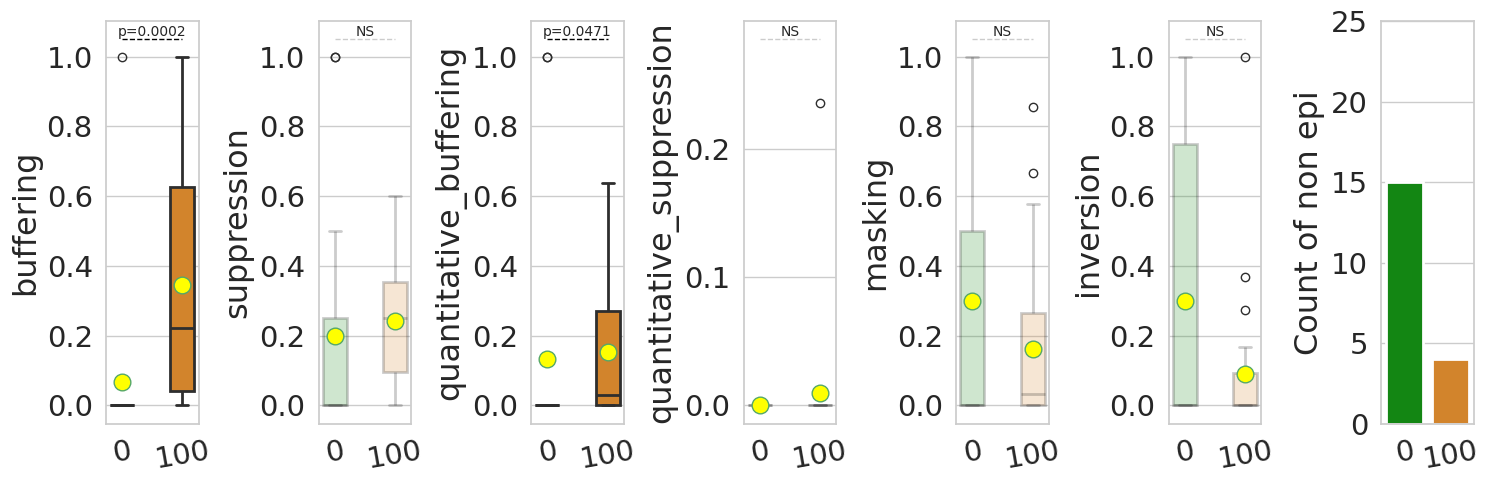

>> reg2m2


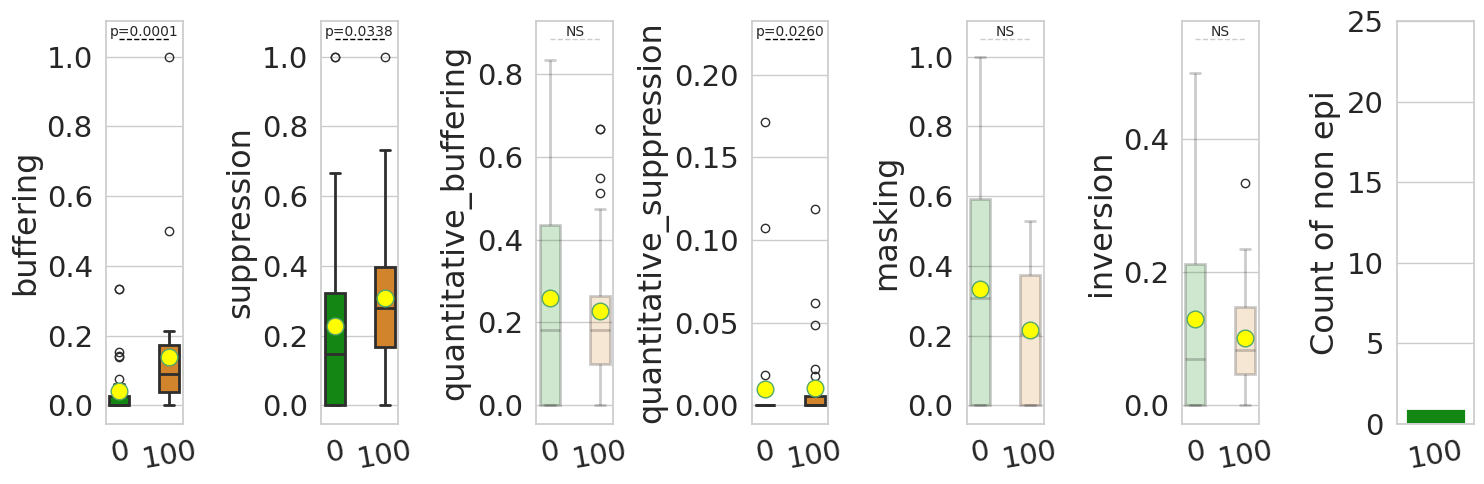

>>>>> symmetry
>> reg10m2


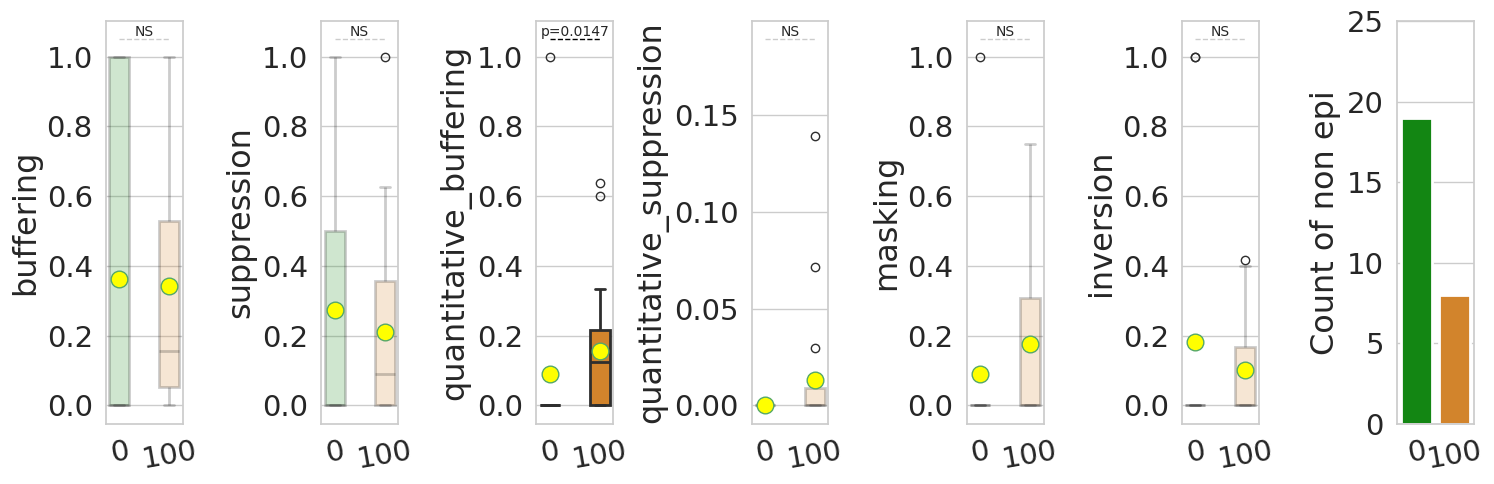

>> reg2m2


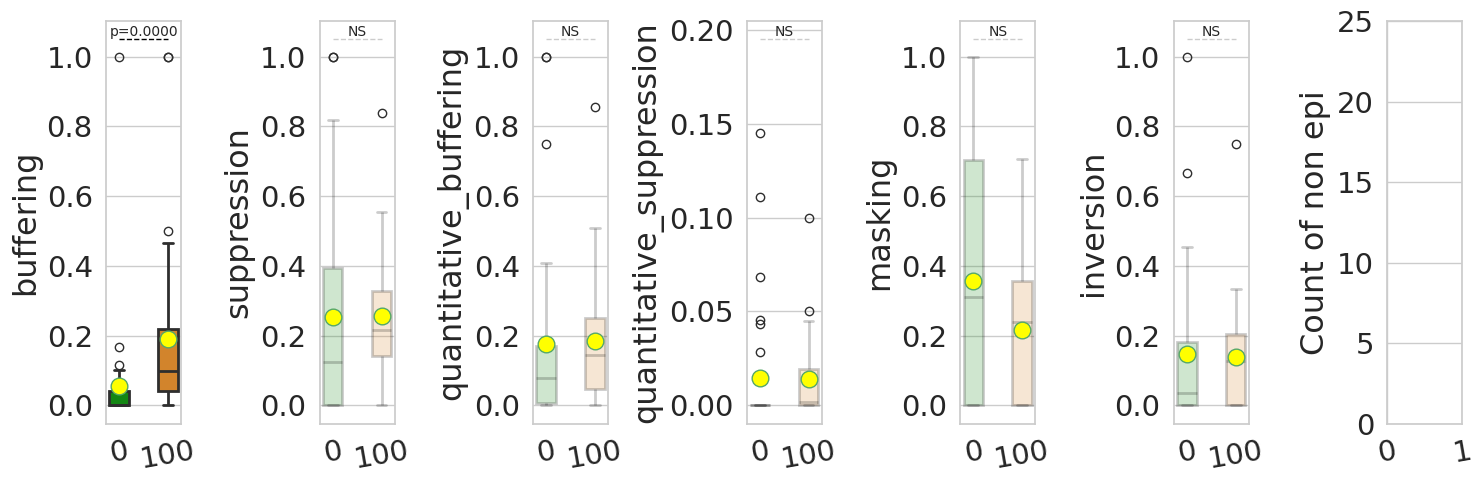

In [137]:
### EPISTASIS CATEG CHANGES ###
 
metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
sb.set_style("whitegrid")

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
   
        df_trait_exp_zero = df_trait_exp[ (df_trait_exp['epistasis'] == 0) ] 
        df_trait_exp = df_trait_exp[ (df_trait_exp['epistasis'] > 0) ] 
   
        df_trait_exp[metrics] = df_trait_exp[metrics].fillna(0)
        
        fig, axes = plt.subplots(1, 7, figsize=(15, 5))  #
       
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
            #print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
    
            y_max = filtered_clean[f'{metric}'].max() + 0.05             
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
      
            ax.tick_params(axis='x', labelrotation=10)
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')


        ax = axes[idx+1]

        # Create a bar plot to count the number of rows for each 'gen'
        sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=2, ax=ax)
        
        # Customize the plot
        ax.tick_params(axis='x', labelrotation=10)
        ax.set_xlabel('')
        ax.set_ylabel(f'Count of non epi')
        ax.set_ylim(0, 25) 
        
        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()
    


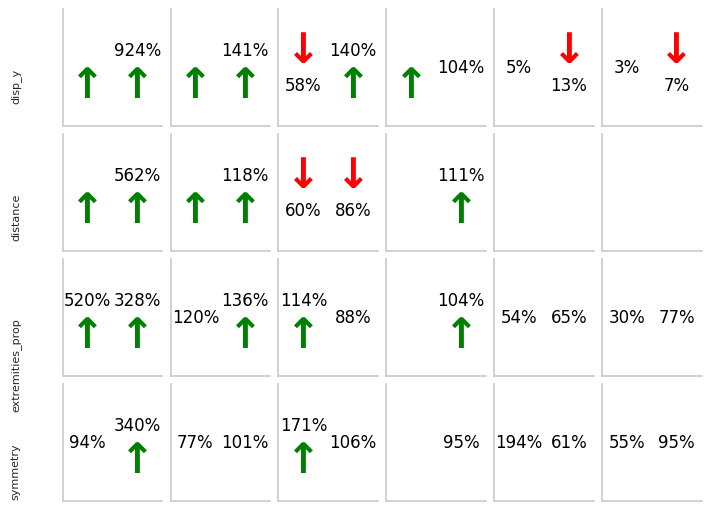

In [138]:
# Create a figure for the grid
fig, ax = plt.subplots(len(traits), len(metrics), figsize=(7, 5), constrained_layout=True)

for i, trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True)
    for j, metric in enumerate(metrics):
        for k, exp in enumerate(experiments):
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')

            # Calculate the ratio of gen 100 to gen 0
            ratio = (avg_end_gen / avg_ini_gen) * 100

            # Determine the subcell width and x-position for horizontal stacking
            subcell_width = 1.0 / len(experiments)
            x_position = k * subcell_width

            if ratio != np.inf and ratio != -np.inf and not(np.isnan(ratio)):
                display_text = f'{ratio:.0f}%'
            else:
                display_text = ''
                
            # Determine what to display in the subcell
            if p_value >= 0.05:
              #  ax[i, j].plot([x_position + 0.20 * subcell_width, x_position + 0.7 * subcell_width], [0.5, 0.5], color='black', linewidth=2)
                ax[i, j].text(x_position + subcell_width / 2, 0.5, display_text, ha='center', va='center', fontsize=12, color='black')
            else:
                if ratio > 100:
                    # Green arrow pointing up, below the text
                    ax[i, j].text(x_position + subcell_width / 2, 0.65, display_text, ha='center', va='center', fontsize=12, color='black')
                    ax[i, j].annotate('↑', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                                      textcoords='axes fraction', ha='center', va='center', color='green', fontsize=30, fontweight='bold')
                else:
                    # Red arrow pointing down, above the text
                    ax[i, j].text(x_position + subcell_width / 2, 0.35, display_text, ha='center', va='center', fontsize=12, color='black')
                    ax[i, j].annotate('↓', xy=(x_position + subcell_width / 2, 0.65), xytext=(x_position + subcell_width / 2, 0.65),
                                      textcoords='axes fraction', ha='center', va='center', color='red', fontsize=30, fontweight='bold')

            # Draw the borders for each metric cell and subcells
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].spines['left'].set_visible(True)        

            # Draw the borders for the subcells
            ax[i, j].add_patch(plt.Rectangle((x_position, 0), subcell_width, 1, fill=False, edgecolor='white', lw=0.5))

        # Set the grid borders
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Set row labels for traits
for i, trait in enumerate(traits):
    ax[i, 0].set_ylabel(trait, fontsize=8, rotation=90, labelpad=30, ha='right')

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_categ_change.png', dpi=300, bbox_inches='tight')


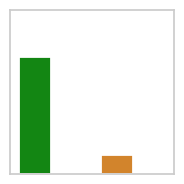

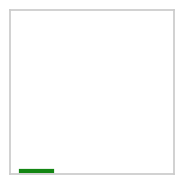

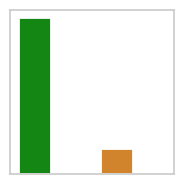

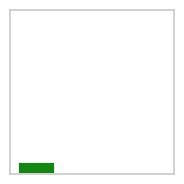

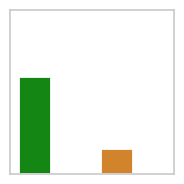

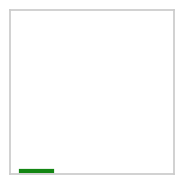

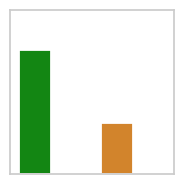

In [139]:
import seaborn as sb
import matplotlib.pyplot as plt

metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900', '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4], 'extremities_prop': [-0.05, 1.1], 'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
sb.set_style("whitegrid")

for trait in traits:
    #print('>>>>>', trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        #print('>>', exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']
        
        df_trait_exp_zero = df_trait_exp[df_trait_exp['epistasis'] == 0]
        
        # Count the number of rows in df_trait_exp_zero
        num_rows = df_trait_exp_zero.shape[0]
        #print(f'The number of rows in df_trait_exp_zero is: {num_rows}')
        
        if num_rows > 0:
            fig, ax = plt.subplots(1, 1, figsize=(2, 2))

            # Create countplot
            sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=2, ax=ax)
            
            # Remove x-axis labels
            ax.set_xticklabels([''] * len(ax.get_xticks()))

            # Consistent bar width
            for patch in ax.patches:
                patch.set_width(0.4)  # Adjust width to keep it consistent

            # Add a dummy bar if there's only one bar
            if len(ax.patches) == 1:
                ax.bar(1, 0, width=0.4, color='white', edgecolor='white')  # Invisible bar to maintain spacing

            # Remove y-axis labels
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Set y-axis limit
            ax.set_ylim(0, 25)
            
            # Adjust the layout and display the plot
            plt.tight_layout()
            ax.grid(False)
            plt.show()
            
            fig.savefig(f'{path}/knockouts/epistasis_nochange_{trait}_{exp}.png', dpi=300, bbox_inches='tight')

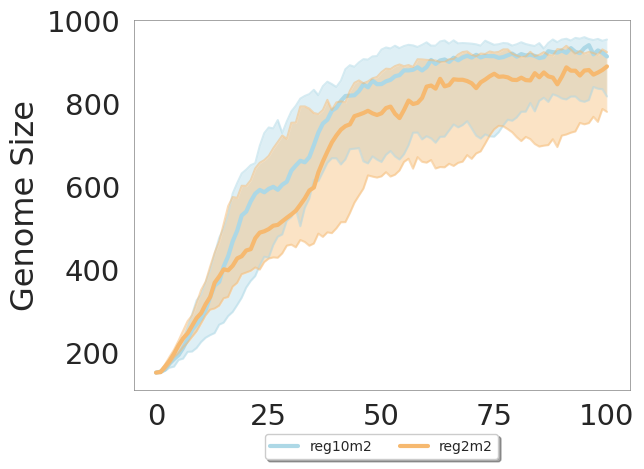

<Figure size 640x480 with 0 Axes>

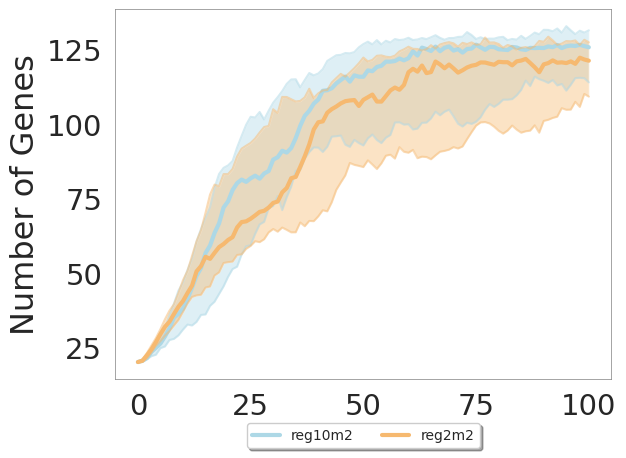

<Figure size 640x480 with 0 Axes>

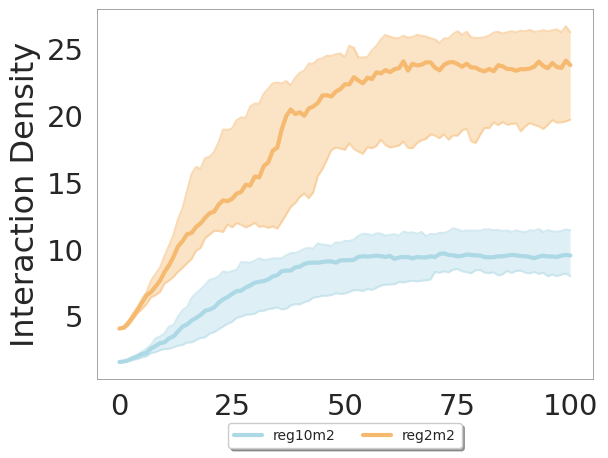

<Figure size 640x480 with 0 Axes>

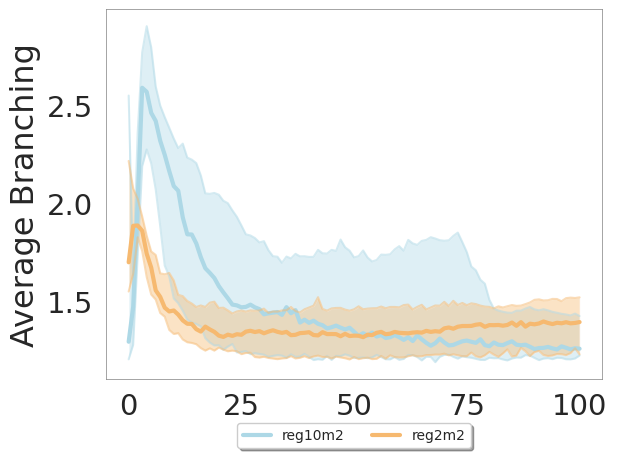

<Figure size 640x480 with 0 Axes>

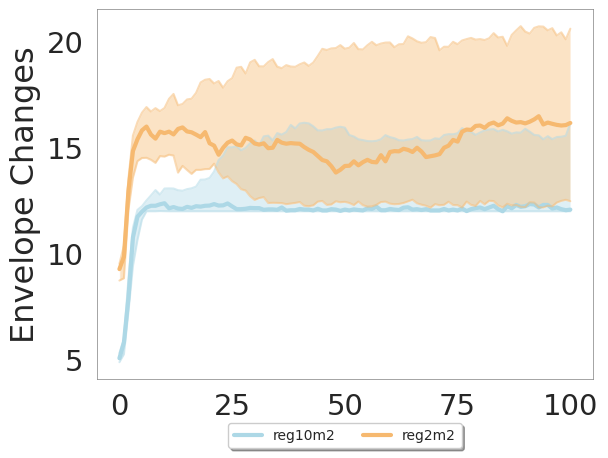


 reg10m2 
 corr all: dispy and n_genes
Pearson Correlation Coefficient: 0.5208483923733376
P-value: 0.0

 reg2m2 
 corr all: dispy and n_genes
Pearson Correlation Coefficient: 0.46718122525099937
P-value: 0.0

 reg10m2 
 corr final: dispy and n_genes
Pearson Correlation Coefficient: 0.2769042928426577
P-value: 8.073049029490699e-54

 reg2m2 
 corr final: dispy and n_genes
Pearson Correlation Coefficient: 0.15514362473043058
P-value: 1.3575769040273783e-17


<Figure size 640x480 with 0 Axes>

In [140]:

### COMPLEXITY AND GENO SIZE PROGRESSION

keys = ['experiment_name', 'run', 'gen', 'individual_id']

df_complexity = pd.read_csv(f'{path}/complexity/complexity.csv').drop(columns=['geno_size'])
df_complexity_net = pd.read_csv(f'{path}/complexity/complexity_net.csv')
df_complexity_all = pd.merge(df_complexity, df_complexity_net, on=keys, how='inner')

df_complexity_all['interactions_density'] = df_complexity_all['complexity_net'] / df_complexity_all['n_genes']

grouped = df_complexity_all.groupby(['experiment_name', 'run', 'gen'])
df_complexity_inner = grouped.agg({
    'geno_size': 'mean',
    'complexity_branch': 'mean',
    'complexity_env': 'mean',
    'n_genes': 'mean',
    'interactions_density': 'mean'
})
df_complexity_inner = df_complexity_inner.reset_index()

q1 = lambda x: x.quantile(0.25)
q3 = lambda x: x.quantile(0.75)

grouped = df_complexity_inner.groupby(['experiment_name', 'gen'])
df_complexity_outer = grouped.agg({
    'geno_size': ['median', q1, q3],
    'complexity_branch': ['median', q1, q3],
    'complexity_env': ['median', q1, q3],
    'n_genes': ['median', q1, q3],
    'interactions_density': ['median', q1, q3]
})
df_complexity_outer.columns = [
    ('geno_size', 'median'), ('geno_size', 'Q1'), ('geno_size', 'Q3'),
    ('complexity_branch', 'median'), ('complexity_branch', 'Q1'), ('complexity_branch', 'Q3'),
    ('complexity_env', 'median'), ('complexity_env', 'Q1'), ('complexity_env', 'Q3'),
    ('n_genes', 'median'), ('n_genes', 'Q1'), ('n_genes', 'Q3'),
    ('interactions_density', 'median'), ('interactions_density', 'Q1'), ('interactions_density', 'Q3')
]
df_complexity_outer.columns = ['_'.join(col) for col in df_complexity_outer.columns]
df_complexity_outer = df_complexity_outer.reset_index()

clrs = ['#ADD8E6',
        '#F6B970']
traits_labels = ['Genome Size', 'Number of Genes', 'Interaction Density', 'Average Branching', 'Envelope Changes']

metrics = ['geno_size', 'n_genes', 'interactions_density', 'complexity_branch', 'complexity_env']
for idm, metric in enumerate(metrics):

    font = {'font.size': 20}
    plt.rcParams.update(font)
    fig, ax = plt.subplots()#figsize=(3,2))

    plt.xlabel('')
    plt.ylabel(f'{traits_labels[idm]}')
    ax.grid(False)
    ax.spines['top'].set_color('grey')
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_color('grey')
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)



    for idx_experiment, exp in enumerate(experiments):
        metric_exp = df_complexity_outer[df_complexity_outer['experiment_name'] == exp]
        #display(metric_exp)

        ax.plot(metric_exp['gen'], metric_exp[f'{metric}_median'],
                    label=f'{exp}', c=clrs[idx_experiment], linewidth=3)
        
        ax.fill_between(metric_exp['gen'],
                        metric_exp[f'{metric}_Q1'],
                        metric_exp[f'{metric}_Q3'],
                        alpha=0.4, facecolor=clrs[idx_experiment])
        
        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q1'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q1

        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q3'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q3

        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  fancybox=True, shadow=True, ncol=5, fontsize=10)

    plt.show()
    plt.clf()
    fig.savefig(f'{path}/knockouts/{metric}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



for idx_experiment, exp in enumerate(experiments):
    print('\n',exp, '\n corr all: dispy and n_genes')
    df_complexity_exp = df_complexity_all[df_complexity_all['experiment_name'] == exp]
    df_complexity_exp[['disp_y', 'n_genes']] = df_complexity_exp[['disp_y', 'n_genes']].replace([np.inf, -np.inf], np.nan)
    df_complexity_exp = df_complexity_exp[['disp_y', 'n_genes']].dropna()

    corr_coefficient, p_value = pearsonr(df_complexity_exp['disp_y'], df_complexity_exp['n_genes'])
    print(f"Pearson Correlation Coefficient: {corr_coefficient}")
    print(f"P-value: {p_value}")


for idx_experiment, exp in enumerate(experiments):
    print('\n',exp, '\n corr final: dispy and n_genes')
    df_complexity_exp = df_complexity_all[df_complexity_all['experiment_name'] == exp]
    df_complexity_exp = df_complexity_exp[df_complexity_exp['gen'] == 100]
    df_complexity_exp[['disp_y', 'n_genes']] = df_complexity_exp[['disp_y', 'n_genes']].replace([np.inf, -np.inf], np.nan)
    df_complexity_exp = df_complexity_exp[['disp_y', 'n_genes']].dropna()

    corr_coefficient, p_value = pearsonr(df_complexity_exp['disp_y'], df_complexity_exp['n_genes'])
    print(f"Pearson Correlation Coefficient: {corr_coefficient}")
    print(f"P-value: {p_value}")



>> reg10m2


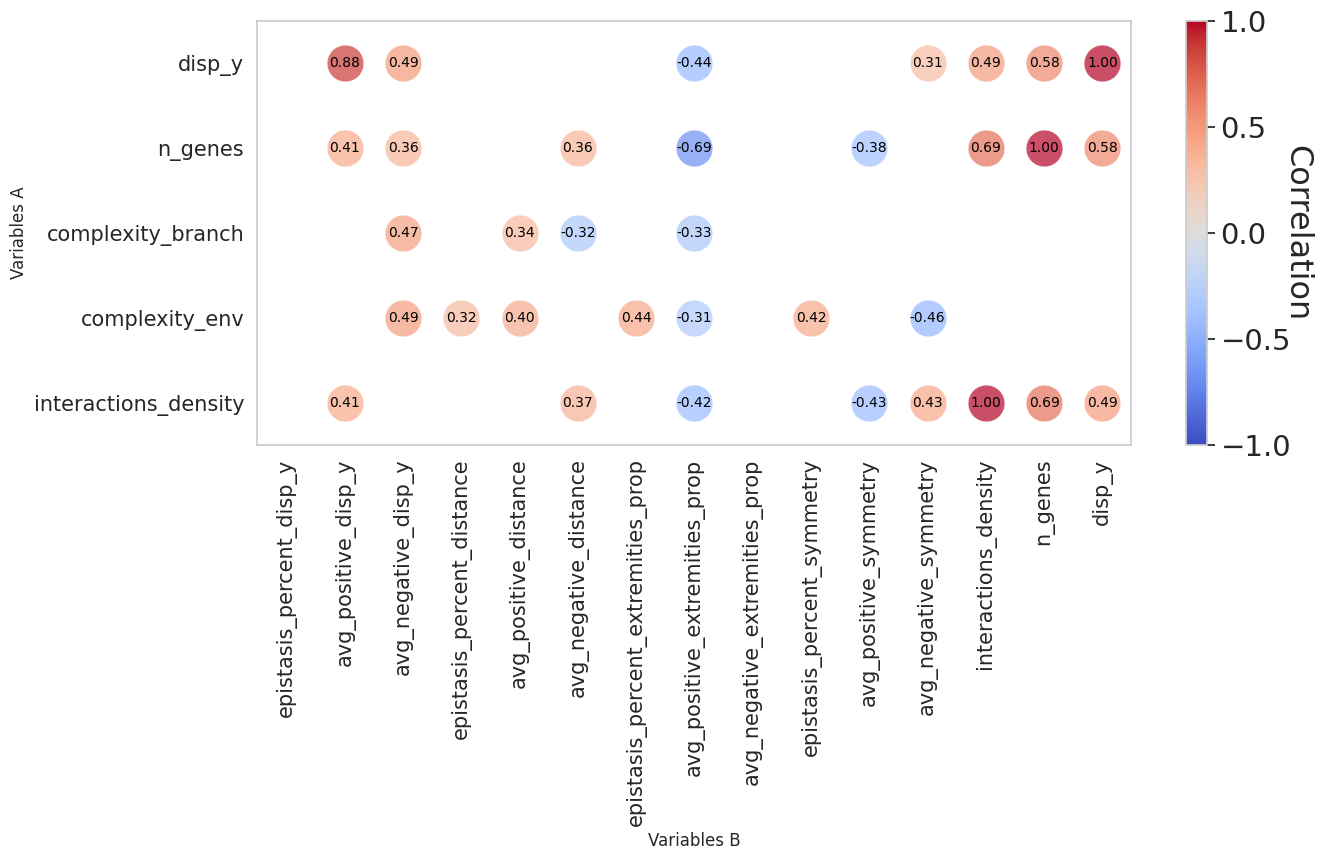

>> reg2m2


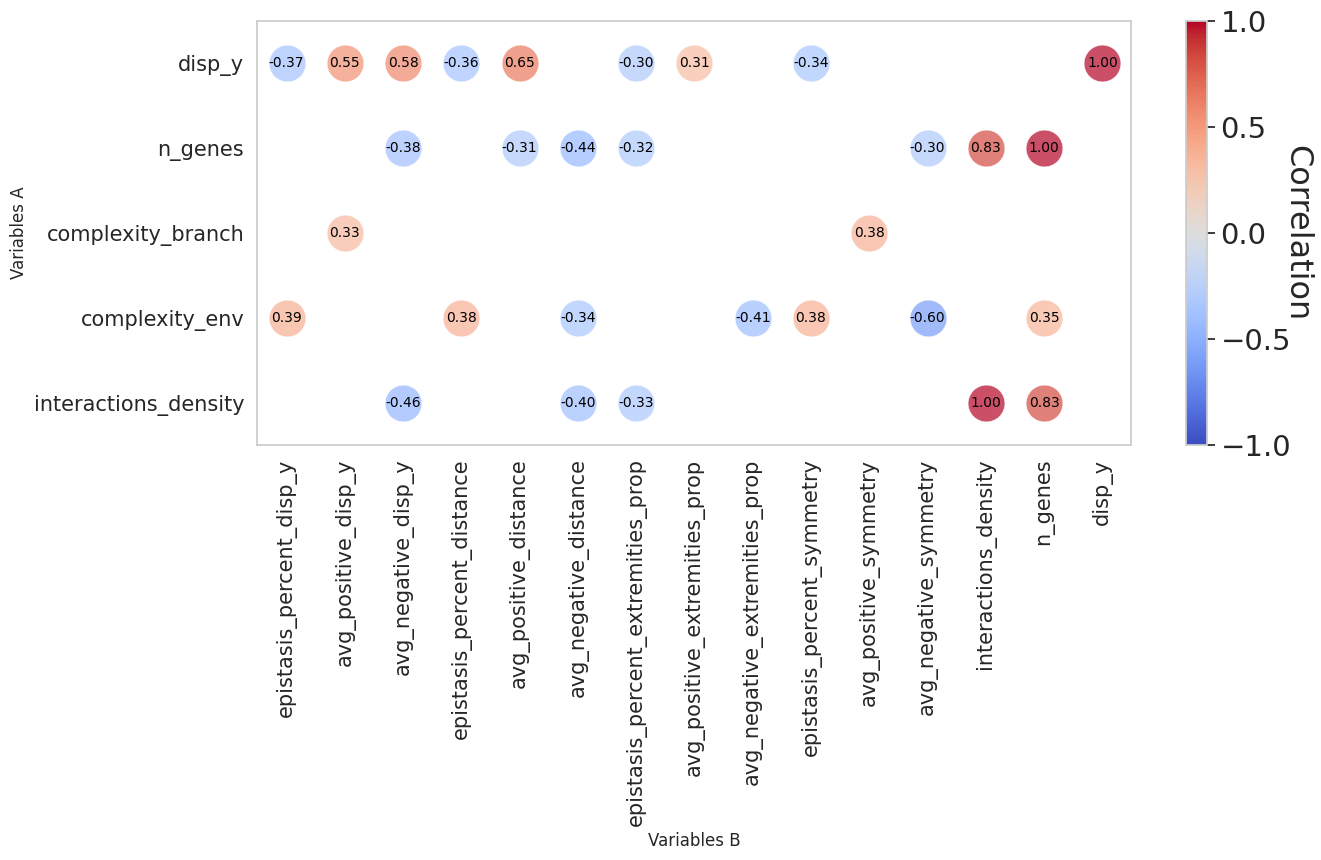

In [52]:
### CORRELATIONS: EPISTASIS VS PHENOCOMPLEXITY


df_complexity_end = df_complexity_all[(df_complexity_all['gen'] == 100)]

metrics1 = ['disp_y','n_genes', 'complexity_branch', 'complexity_env', 'interactions_density']
#metrics1 = ['disp_y', 'complexity_branch', 'complexity_env', 'complexity_net']

metrics2 = []

for idx,trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')
    corr_df = corr_df.rename(columns={'epistasis_percent': 'epistasis_percent_'+trait, 
                                      'avg_positive': 'avg_positive_'+trait, 
                                      'avg_negative': 'avg_negative_'+trait})
    metrics2.append('epistasis_percent_'+trait)
    metrics2.append('avg_positive_'+trait)
    metrics2.append('avg_negative_'+trait)
   
    obsolete_vars = ['symmetry', 'extremities_prop' ,'neutral', 'positive', 'negative', 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes' ,'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')


for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
   # display(df_complexity_end_exp)

    corr_matrix = df_complexity_end_exp[metrics1+metrics2].corr()
    corr_matrix = corr_matrix.loc[metrics1, metrics2+['interactions_density', 'n_genes', 'disp_y'] ] 
   # display(corr_matrix)

    ##################################
    # Filter out correlations below the threshold
    threshold = 0.3
    filtered_corr_matrix = corr_matrix.copy()
    filtered_corr_matrix[abs(filtered_corr_matrix) < threshold] = np.nan
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Define color map and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=-1, vmax=1)
   
    # Plot each circle based on the filtered correlation matrix
    for i, var_a in enumerate(filtered_corr_matrix.index):
        for j, var_b in enumerate(filtered_corr_matrix.columns):
            corr_value = filtered_corr_matrix.loc[var_a, var_b]
            if not np.isnan(corr_value):
                size = abs(corr_value) * 3000  # Scale size of the circle
                color = cmap(norm(corr_value))  # Map correlation to color (blue to red)
                
                # Plot a circle at the grid position
                ax.scatter(j, i, color=color, alpha=0.7, edgecolors='w', linewidth=0.5, s=700) #, s=size )
                ax.text(j, i, f'{corr_value:.2f}', color='black', fontsize=10, ha='center', va='center')
    
    # Set labels and title
    ax.set_xticks(range(len(filtered_corr_matrix.columns)))
    ax.set_yticks(range(len(filtered_corr_matrix.index)))
    ax.set_xticklabels(filtered_corr_matrix.columns, rotation=90, fontsize=15)  # Smaller font size
    ax.set_yticklabels(filtered_corr_matrix.index, fontsize=15)  # Smaller font size
    ax.set_xlabel('Variables B', size=12)
    ax.set_ylabel('Variables A', size=12)
    ax.set_title('', size=16)
    
    # Adjust the spacing between plot elements
    ax.set_xlim(-0.5, len(filtered_corr_matrix.columns) - 0.5)  # Ensure circles don't go out of bounds horizontally
    ax.set_ylim(len(filtered_corr_matrix.index) - 0.5, -0.5)   # Ensure circles don't go out of bounds vertically
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(sm)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    # Add size legend
    #sizes = [100, 500, 1000]  # Sizes for the legend
    #size_labels = [f'{size/1000:.1f}' for size in sizes]
    #patches = [mpatches.Circle((0, 0), radius=np.sqrt(size/1000), color='grey', alpha=0.7) for size in sizes]
    #ax.legend(patches, size_labels, title="Correlation Strength", title_fontsize='13', loc='upper right', fontsize='10', frameon=False)
    
    # Show the plot
    plt.grid(False)
    plt.tight_layout()
    plt.show()



>> reg10m2


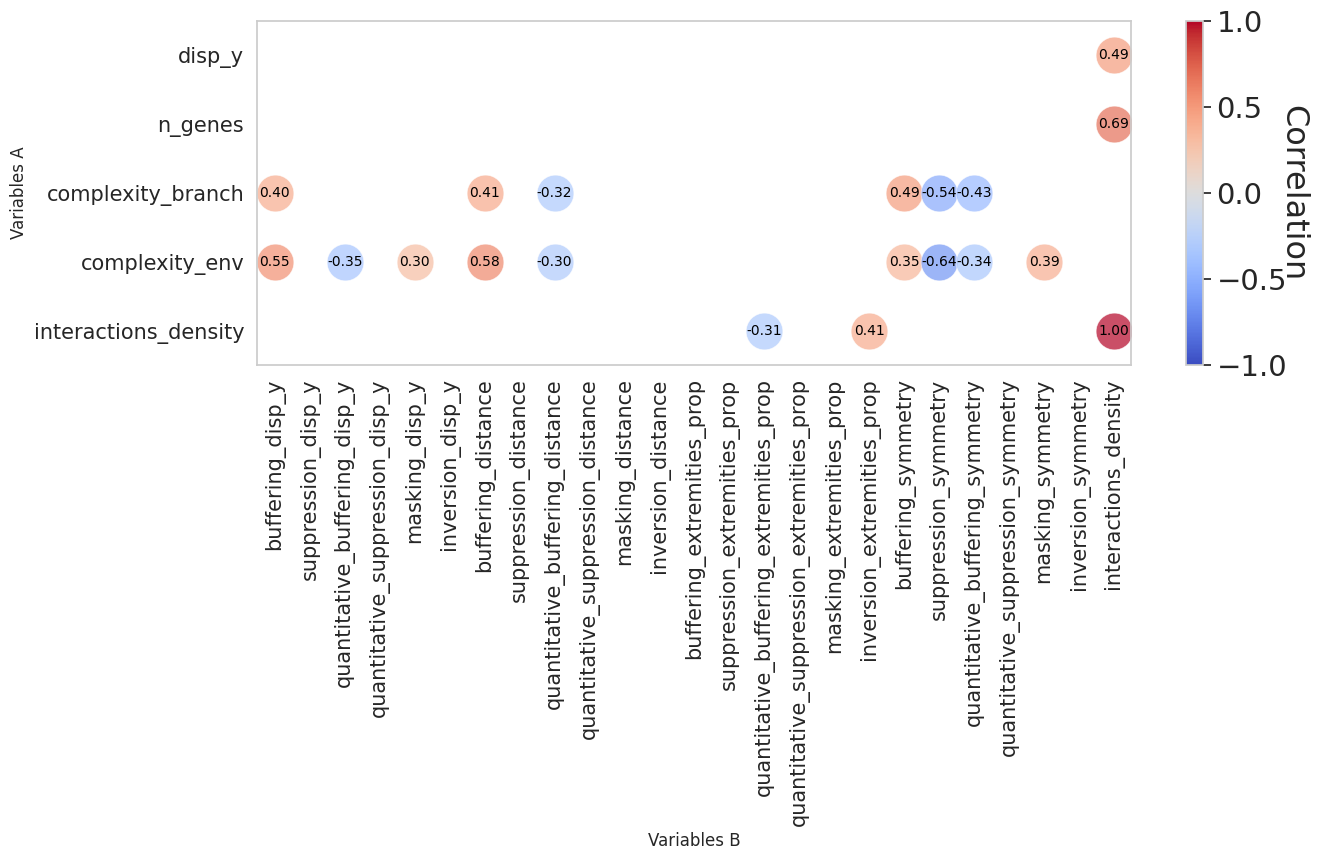

>> reg2m2


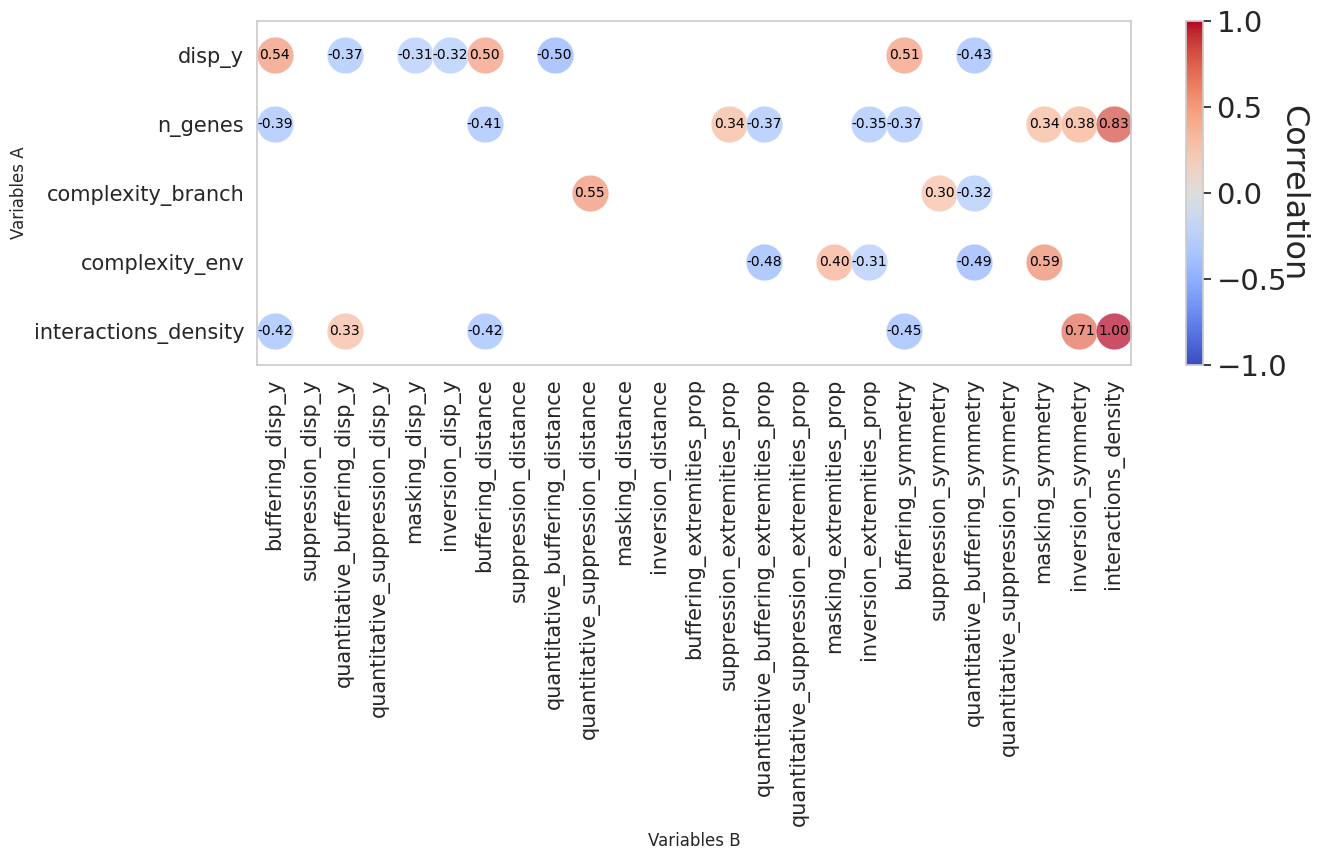

In [56]:
### CORRELATIONS: CATEG EPISTASIS VS PHENOCOMPLEXITY

metrics1 = ['disp_y','n_genes', 'complexity_branch', 'complexity_env', 'interactions_density']

metrics2 = []

for idx,trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')
    corr_df = corr_df.rename(columns={'buffering': 'buffering_'+trait, 
                                      'suppression': 'suppression_'+trait, 
                                      'quantitative_buffering': 'quantitative_buffering_'+trait,
                                      'quantitative_suppression': 'quantitative_suppression_'+trait,
                                      'masking': 'masking_'+trait,
                                      'inversion': 'inversion_'+trait
                                     })
    metrics2.append('buffering_'+trait)
    metrics2.append('suppression_'+trait)
    metrics2.append('quantitative_buffering_'+trait)
    metrics2.append('quantitative_suppression_'+trait)
    metrics2.append('masking_'+trait)
    metrics2.append('inversion_'+trait)

    obsolete_vars = ['symmetry', 'extremities_prop' , 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes', 'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')


for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    #display(df_complexity_end_exp)

    corr_matrix = df_complexity_end_exp[metrics1+metrics2].corr()
    corr_matrix = corr_matrix.loc[metrics1, metrics2+['interactions_density'] ] 
   # display(corr_matrix)

    ##################################
    # Filter out correlations below the threshold
    threshold = 0.3
    filtered_corr_matrix = corr_matrix.copy()
    filtered_corr_matrix[abs(filtered_corr_matrix) < threshold] = np.nan
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Define color map and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=-1, vmax=1)
   
    # Plot each circle based on the filtered correlation matrix
    for i, var_a in enumerate(filtered_corr_matrix.index):
        for j, var_b in enumerate(filtered_corr_matrix.columns):
            corr_value = filtered_corr_matrix.loc[var_a, var_b]
            if not np.isnan(corr_value):
                size = abs(corr_value) * 3000  # Scale size of the circle
                color = cmap(norm(corr_value))  # Map correlation to color (blue to red)
                
                # Plot a circle at the grid position
                ax.scatter(j, i, color=color, alpha=0.7, edgecolors='w', linewidth=0.5, s=700) #, s=size )
                ax.text(j, i, f'{corr_value:.2f}', color='black', fontsize=10, ha='center', va='center')
    
    # Set labels and title
    ax.set_xticks(range(len(filtered_corr_matrix.columns)))
    ax.set_yticks(range(len(filtered_corr_matrix.index)))
    ax.set_xticklabels(filtered_corr_matrix.columns, rotation=90, fontsize=15)  # Smaller font size
    ax.set_yticklabels(filtered_corr_matrix.index, fontsize=15)  # Smaller font size
    ax.set_xlabel('Variables B', size=12)
    ax.set_ylabel('Variables A', size=12)
    ax.set_title('', size=16)
    
    # Adjust the spacing between plot elements
    ax.set_xlim(-0.5, len(filtered_corr_matrix.columns) - 0.5)  # Ensure circles don't go out of bounds horizontally
    ax.set_ylim(len(filtered_corr_matrix.index) - 0.5, -0.5)   # Ensure circles don't go out of bounds vertically
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(sm)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    # Add size legend
    #sizes = [100, 500, 1000]  # Sizes for the legend
    #size_labels = [f'{size/1000:.1f}' for size in sizes]
    #patches = [mpatches.Circle((0, 0), radius=np.sqrt(size/1000), color='grey', alpha=0.7) for size in sizes]
    #ax.legend(patches, size_labels, title="Correlation Strength", title_fontsize='13', loc='upper right', fontsize='10', frameon=False)
    
    # Show the plot
    plt.grid(False)
    plt.tight_layout()
    plt.show()





 >>>>> complexity_env

 >>> reg10m2
Average of 'b' in the first : 14.8
Average of 'b' in the second : 15.466666666666667
  p-value: 0.7886

 >>> reg2m2
Average of 'b' in the first : 14.933333333333334
Average of 'b' in the second : 17.733333333333334
  p-value: 0.1475

 >>>>> complexity_net

 >>> reg10m2
Average of 'b' in the first : 751.5333333333333
Average of 'b' in the second : 1672.4666666666667
  p-value: 0.0

 >>> reg2m2
Average of 'b' in the first : 1266.3333333333333
Average of 'b' in the second : 3987.6666666666665
  p-value: 0.0

 >>>>> disp_y

 >>> reg10m2
Average of 'b' in the first : 1.2517921540305315
Average of 'b' in the second : 1.8696160504827266
  p-value: 0.0043

 >>> reg2m2
Average of 'b' in the first : 2.1201436329943424
Average of 'b' in the second : 2.162267770400892
  p-value: 0.8098


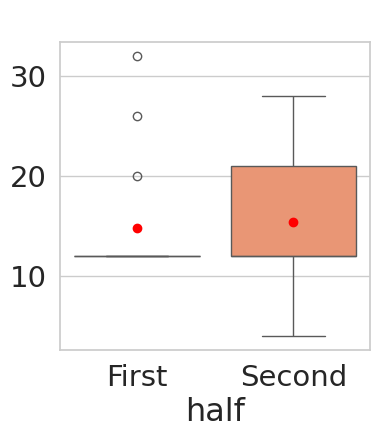

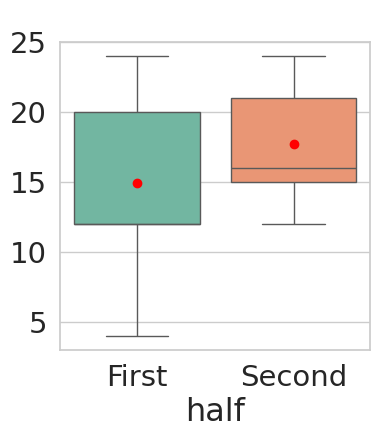

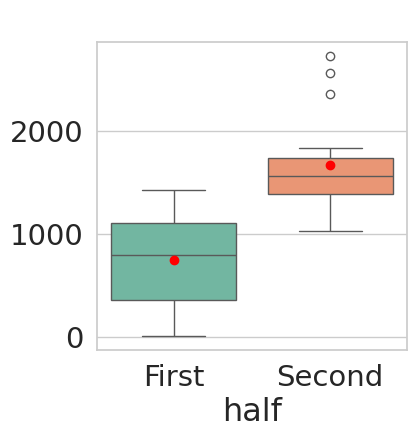

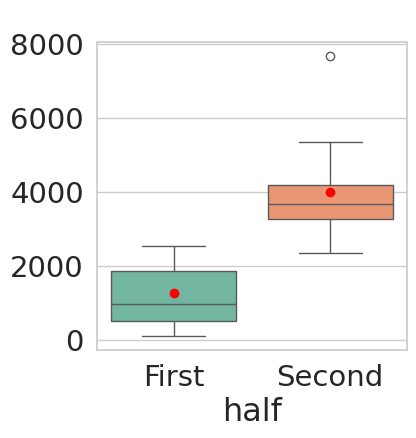

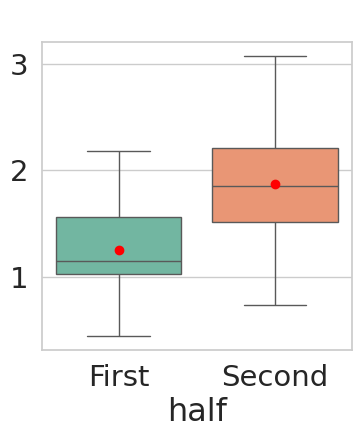

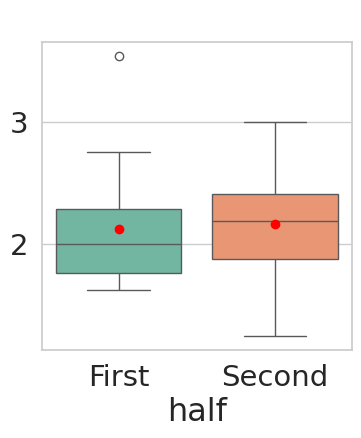

In [58]:

### COMPLEXITY VS SIZE 


metrics_dist = ['complexity_env', 'complexity_net', 'disp_y']
metric_order = 'n_genes'

for metric_dist in metrics_dist:
    print('\n >>>>>',metric_dist)
    for exp in experiments:
        print('\n >>>',exp)
        df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
        df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
        df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
               
        # first_half = df_comp_g[ (df_comp_g[metric_order] <20) ] 
        # second_half = df_comp_g[ (df_comp_g[metric_order] >= 20) ] 

        midpoint = len(df_sorted) // 2
        first_half = df_sorted.iloc[:midpoint]
        second_half = df_sorted.iloc[midpoint:]
        
        # Calculate and display the averages for 'b' in each half
        avg_first_half = first_half[metric_dist].mean()
        avg_second_half = second_half[metric_dist].mean()
        #display(first_half)
      #  display(second_half)
        print(f"Average of 'b' in the first : {avg_first_half}")
        print(f"Average of 'b' in the second : {avg_second_half}")
        
        t_stat, p_value = ttest_ind(first_half[metric_dist], second_half[metric_dist], equal_var=True)
       # _, p_value = wilcoxon(first_half[metric_dist], second_half[metric_dist])
        #_, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
        print(f"  p-value: {round(p_value, 4)}")
        
        # Add a new column to each half to indicate "First Half" or "Second Half"
        first_half['half'] = 'First'
        second_half['half'] = 'Second'
        
        #  Concatenate the two halves back into a single DataFrame
        df_concat = pd.concat([first_half, second_half], ignore_index=True)
        
        # Plot variable 'disp_y' for each half using box plots
        plt.figure(figsize=(4, 4))
        sb.boxplot(x='half', y=metric_dist, data=df_concat, palette="Set2")
        
        plt.scatter(x=[0], y=[avg_first_half], color='red', label='Mean', zorder=5)
        plt.scatter(x=[1], y=[avg_second_half], color='red', zorder=5)
        
        plt.title(' ')
        plt.ylabel('' )
      #  plt.show() 
